In [2]:
import io
import nbformat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

import re
import csv

In [3]:
data = "train_data.csv"
df1 = pd.read_csv(data)

In [4]:
df1.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
1,2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
2,3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
3,4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
4,6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


In [5]:
#Prepare card id and ip id for plotting

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)


In [21]:
data = "train_data.csv"
df1 = pd.read_csv(data)

#Prepare card id and ip id for plotting

# # 1.Card ID
# card_enc = LabelBinarizer()
# df1['card_id'] = card_enc.fit_transform(df1[])

#
# # 2.IP ID
# ip_enc = LabelBinarizer()
# df1['ip_id'] = ip_enc.fit_transform(df1.ip_id)

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
lb = LabelBinarizer()
y = lb.fit_transform(df1['issuercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['issuercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('issuercountrycode', axis=1), df2], axis=1)

y = lb.fit_transform(df1['shoppercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['shoppercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shoppercountrycode', axis=1), df2], axis=1)

def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

lb2 = LabelBinarizer()
y = lb2.fit_transform(df1['txvariantcode'])

# Create a new DataFrame with the transformed 'txvariantcode' column
df2 = pd.DataFrame(y, columns=['txvariantcode_'+str(i) for i in range(y.shape[1])])

# Replace the 'txvariantcode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('txvariantcode', axis=1), df2], axis=1)

lb3 = LabelBinarizer()
y = lb3.fit_transform(df1['currencycode'])

# Create a new DataFrame with the transformed 'currencycode' column
df2 = pd.DataFrame(y, columns=['currencycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'currencycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('currencycode', axis=1), df2], axis=1)

lb4 = LabelBinarizer()
y = lb4.fit_transform(df1['shopperinteraction'])

# Create a new DataFrame with the transformed 'shopperinteraction' column
df2 = pd.DataFrame(y, columns=['shopperinteraction_'+str(i) for i in range(y.shape[1])])

# Replace the 'shopperinteraction' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shopperinteraction', axis=1), df2], axis=1)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

lb5 = LabelBinarizer()
y = lb5.fit_transform(df1['accountcode_cc'])

# Create a new DataFrame with the transformed 'accountcode_cc' column
df2 = pd.DataFrame(y, columns=['accountcode_cc_'+str(i) for i in range(y.shape[1])])

# Replace the 'accountcode_cc' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('accountcode_cc', axis=1), df2], axis=1)

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3


# X = df1[['issuercountrycode','txvariantcode','bin','amount','currencycode','shoppercountrycode','shopperinteraction','cardverificationcodesupplied','cvcresponsecode','accountcode','mail_id','ip_id','card_id','amount_eur','countries_equal']]


In [22]:
df1.head()

,Id,bin,amount,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,...,currencycode_2,currencycode_3,currencycode_4,shopperinteraction_0,shopperinteraction_1,shopperinteraction_2,accountcode_cc_0,accountcode_cc_1,accountcode_cc_2,accountcode_cc_3
0,1,546097.0,4500.0,True,1,UK,email132571,ip123779,card250169,0,...,0,0,0,0,1,0,0,1,0,0
1,2,557349.0,3395.0,True,1,UK,email312302,ip298387,card14235,0,...,0,0,0,0,1,0,0,1,0,0
2,3,542011.0,3895.0,True,1,UK,email255027,ip260053,card31944,0,...,0,0,0,0,1,0,0,1,0,0
3,4,465943.0,15345.0,False,0,UK,email283167,ip54851,card120871,0,...,0,0,0,1,0,0,0,1,0,0
4,6,475127.0,5095.0,True,1,UK,email325263,ip203929,card208017,0,...,0,0,0,0,1,0,0,1,0,0


In [23]:

# drop id, mail_id, ip_id, card_id
df1 = df1.drop(['Id','mail_id','ip_id','card_id', 'amount', 'accountcode'], axis=1)

In [24]:
# Preprocess your dataset here (e.g., encode categorical variables, scale numerical variables, etc.)

# Separate features and labels
X = df1.drop('label', axis=1)
y = df1['label']

# Split the dataset into a training set (80%) and a testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
# Create and train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [26]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Print the classification report and accuracy
print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37862
           1       0.16      0.09      0.12        64

    accuracy                           1.00     37926
   macro avg       0.58      0.55      0.56     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 0.9976269577598481


Index(['bin', 'cardverificationcodesupplied', 'cvcresponsecode', 'label',
       'countries_equal', 'issuercountrycode_0', 'issuercountrycode_1',
       'issuercountrycode_2', 'issuercountrycode_3', 'issuercountrycode_4',
       ...
       'currencycode_2', 'currencycode_3', 'currencycode_4',
       'shopperinteraction_0', 'shopperinteraction_1', 'shopperinteraction_2',
       'accountcode_cc_0', 'accountcode_cc_1', 'accountcode_cc_2',
       'accountcode_cc_3'],
      dtype='object', length=280)


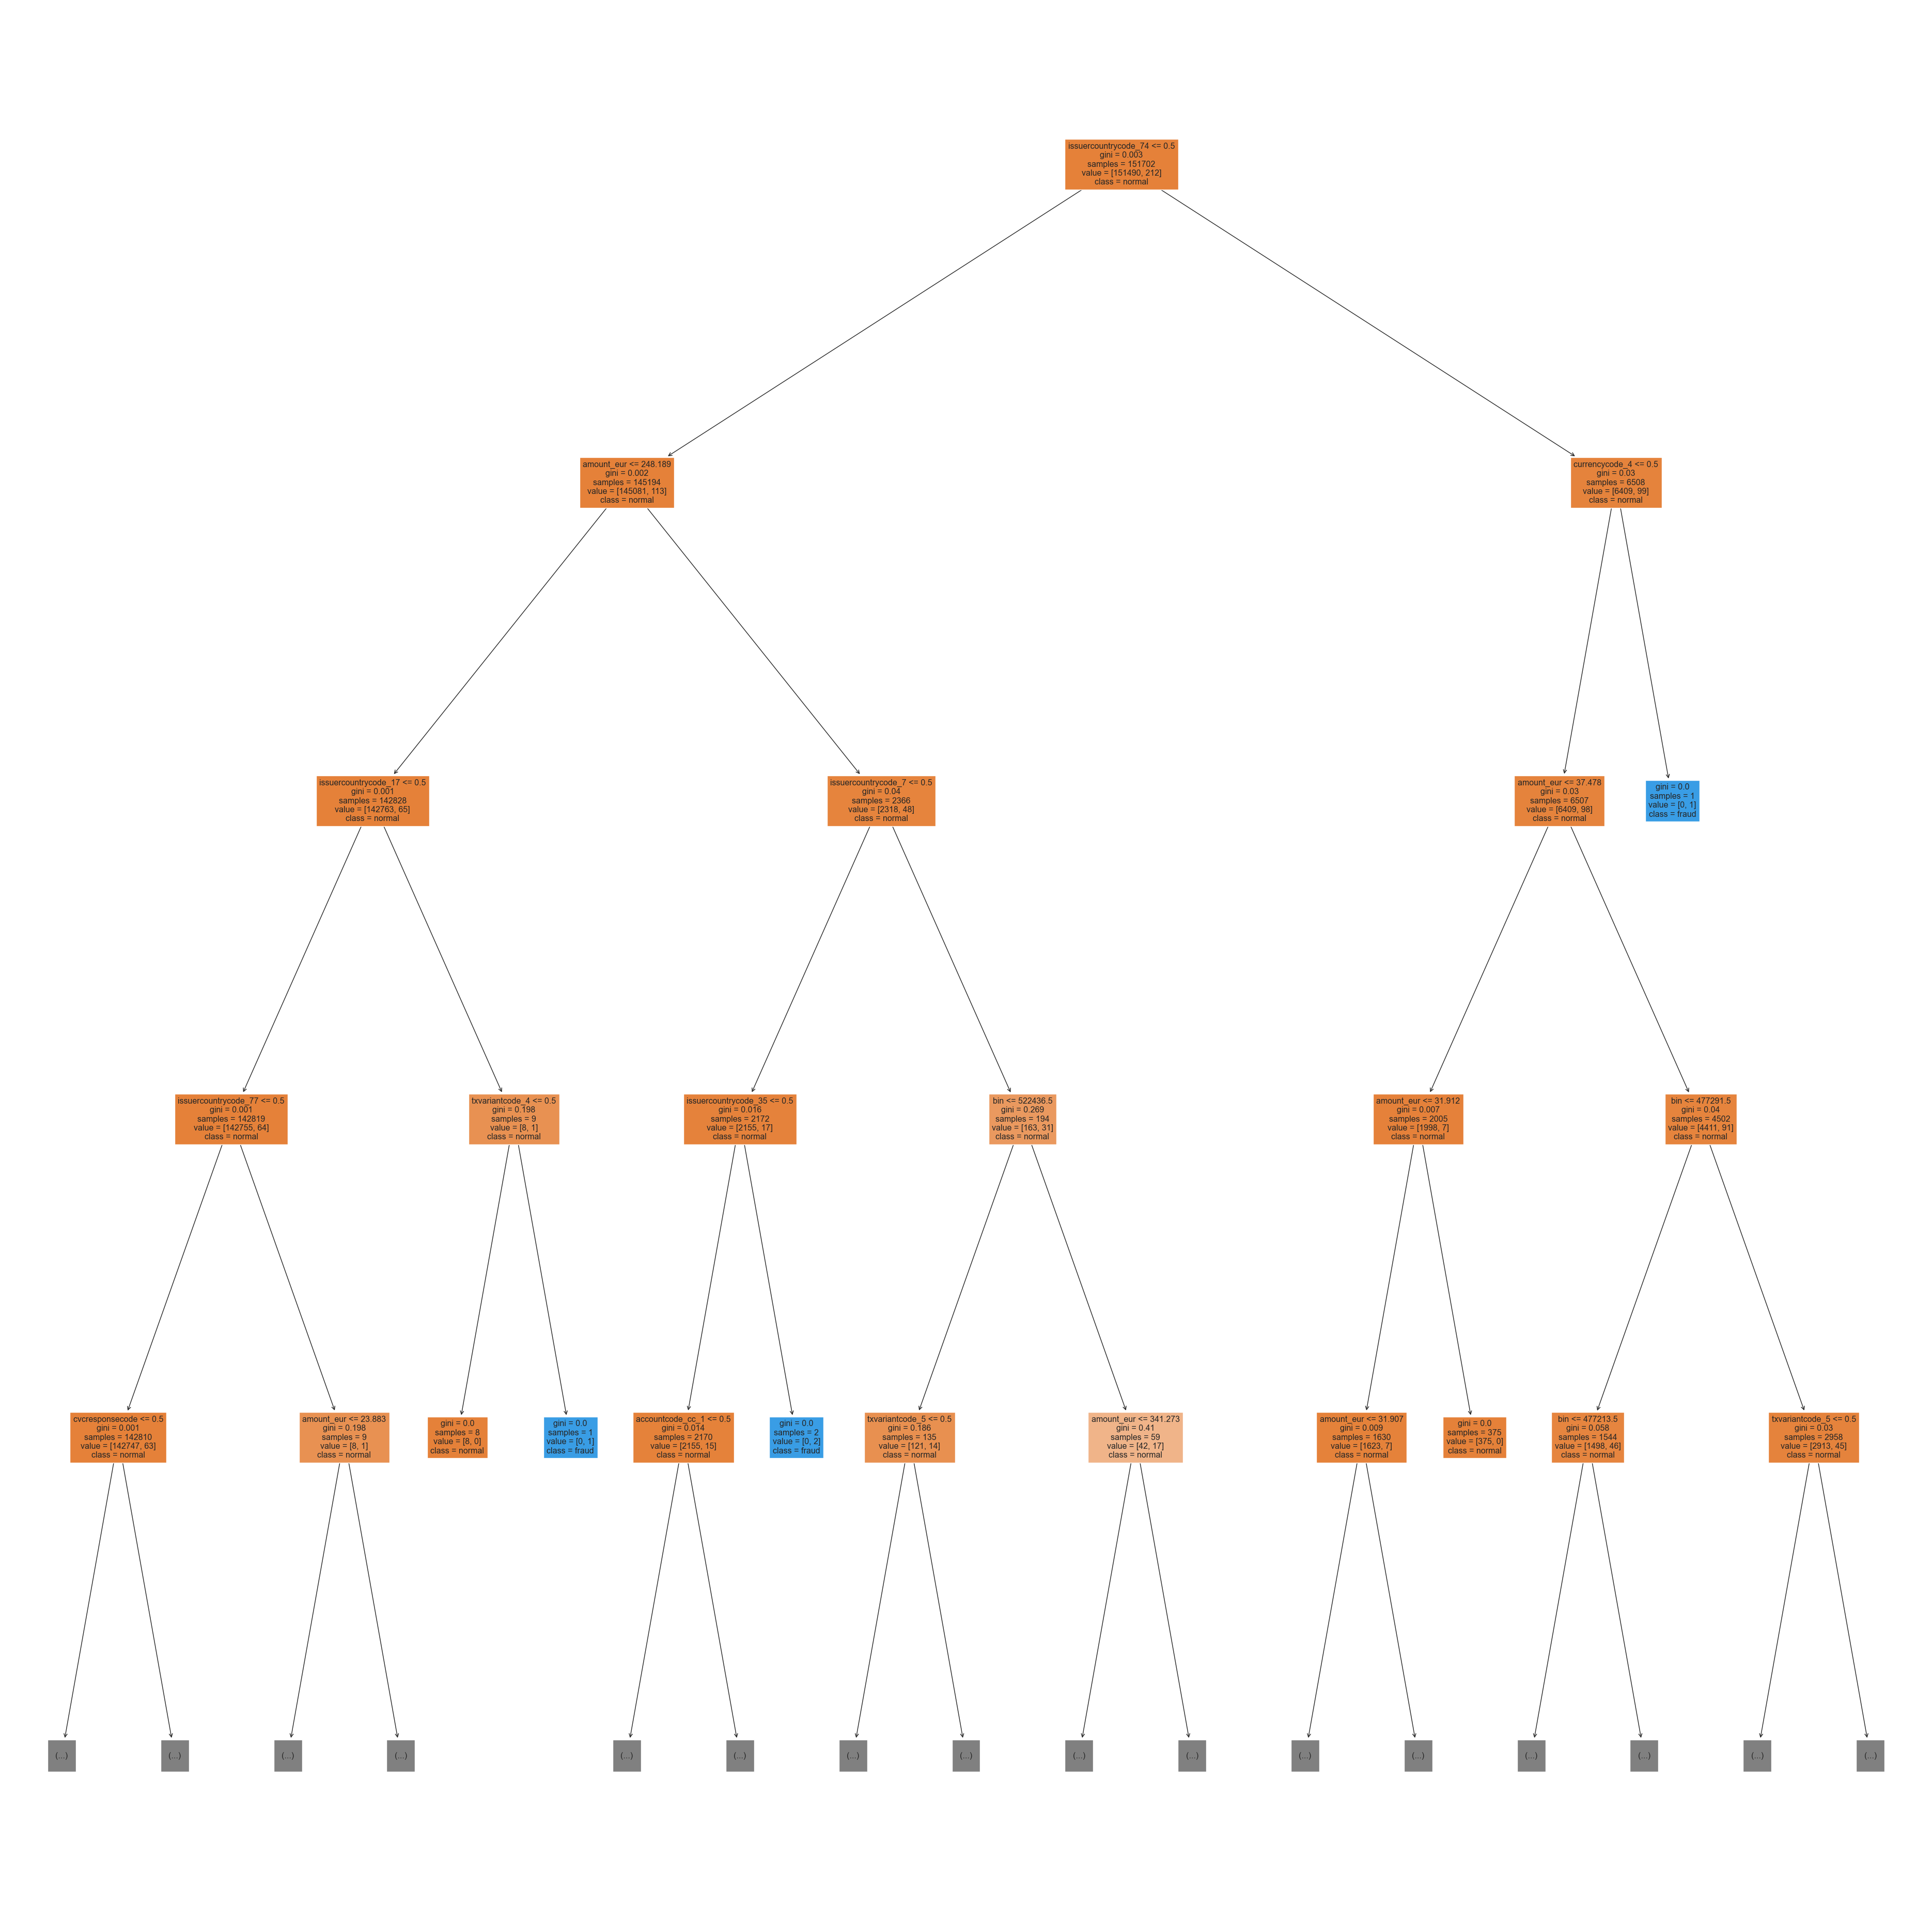

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt


# # Fit the classifier to some data
# X = [[0, 0], [1, 1]]
# y = [0, 1]
# clf.fit(X, y)
# Generate a Graphviz representation of the decision tree
print(df1.columns)
df1_no_label = df1.drop('label', axis=1)
# Visualize the decision tree
plt.figure(figsize=(48, 48))
plot_tree(clf, filled=True, feature_names=df1_no_label.columns, class_names=['normal', 'fraud'], max_depth=4)
plt.show()